### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

### Loading the data

In [4]:
official_names = ['Isopropyl_myristate', 'Benzyl_benzoate', 'Alpha_pinene', 'Limonene', 
                  'Benzyl alcohol', 'Benzyl salicylate', 'Etanol', 'Eugenol', 'Geraniol', 'Menthone']

In [5]:
components_present = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy.csv', skiprows=1, usecols=range(7), 
                      delimiter=',',dtype=float)

In [6]:
ppm_components_present = components_present[:,0]

In [7]:
components_present = components_present[:,[1,2,4,5]] #no menton

In [8]:
components_absent = np.loadtxt(os.getcwd()+'/other_ingredients_corr.csv', skiprows=1, 
                      delimiter=',',dtype=float)

In [9]:
ppm_components_absent = components_absent[:,0]

In [10]:
components_absent = components_absent[:,1:]

In [12]:
mix = np.loadtxt(os.getcwd()+'/Mieszanina_perfumy_bez_menthonu.csv', skiprows=1, usecols=range(2), 
                  delimiter=',',dtype=float)

In [13]:
ppm = mix[:,0]

In [14]:
mix = mix[:,1]

In [15]:
#From email: 2.2449, 0.3269, 0.2533, 0.2651
r_sum = 2.2449 + 0.3269 + 0.2533 + 0.2651
real_proportions = [2.2449/r_sum, 0.3269/r_sum, 0.2533/r_sum, 0.2651/r_sum]
print('Real proportions:')
real_proportions

Real proportions:


[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [16]:
proportions_rescaled = [real_proportions[0]*34, real_proportions[1]*12,
                        real_proportions[2]*16, real_proportions[3]*16]
vis_prop = [x/sum(proportions_rescaled) for x in proportions_rescaled]
print('Proportions that should be visible in mixture computed based on number of H:')
vis_prop

Proportions that should be visible in mixture computed based on number of H:


[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

In [17]:
real_visible_proportions = np.array(vis_prop)#np.array with shape (number of components,)

### Preprocessing

In [18]:
components_present_ints = []
names_present = []
for i in range(components_present.shape[1]):
    components_present_ints.append(components_present[:,i])
    names_present.append('comp'+str(i))

In [19]:
components_absent_ints = []
names_absent = []
for i in range(components_absent.shape[1]):
    components_absent_ints.append(components_absent[:,i])
    names_absent.append('comp'+str(i))

### Additional preprocessing for this specific case

In [20]:
for i, ints in enumerate(components_present_ints):
    components_present_ints[i] = components_present_ints[i][np.logical_and(ppm_components_present>-5,
                                                                           ppm_components_present<15)]
ppm_components_present= ppm_components_present[np.logical_and(ppm_components_present>-5, ppm_components_present<15)]

In [21]:
for i, ints in enumerate(components_absent_ints):
    components_absent_ints[i] = components_absent_ints[i][np.logical_and(ppm_components_absent>-5,
                                                                           ppm_components_absent<15)]
ppm_components_absent= ppm_components_absent[np.logical_and(ppm_components_absent>-5, ppm_components_absent<15)]

In [22]:
mix = mix[np.logical_and(ppm>-5, ppm<15)]

In [23]:
ppm = ppm[np.logical_and(ppm>-5, ppm<15)]

### Shifting one spectrum (limonene) to the right in order to align

NOTE: Run either cell below or the next after the cell below, depending if you want to include the shift in ppm or not.

In [24]:
# #version 15.10.2022.: NO SHIFT IN PPM FOR ANY SPECTRUM
# spectra_present = []
# for i, comp_ints in enumerate(components_present_ints):
# #     if not i==3:
# #         spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))
# #     else:
# #         spectra_present.append(Spectrum(confs=list(zip(ppm_components_present+0.1, comp_ints))))
#     spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))

In [25]:
#version 16.10.2022.: WITH SHIFT IN PPM
spectra_present = []
for i, comp_ints in enumerate(components_present_ints):
    if not i==3:
        spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))
    else:
        spectra_present.append(Spectrum(confs=list(zip(ppm_components_present+0.1, comp_ints))))
    #spectra_present.append(Spectrum(confs=list(zip(ppm_components_present, comp_ints))))

In [26]:
spectra_absent = []
for comp_ints in components_absent_ints:
    spectra_absent.append(Spectrum(confs=list(zip(ppm_components_absent, comp_ints))))

In [27]:
mix = Spectrum(confs=list(zip(ppm,mix)))

In [28]:
#spectra_absent[5].plot(profile=True)

### Additional preprocessing: common mass axis for absent and present components

In [29]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [30]:
present_and_absent_cma = common_mass_axis(spectra_present + spectra_absent)

In [31]:
preprocessed_spectra = []
for sp in (spectra_present + spectra_absent):
    preprocessed_spectra.append(sp.resample(present_and_absent_cma))

In [32]:
#spectra_present[3].plot(profile=True)

In [33]:
ints = []
for sp in preprocessed_spectra:
    ints.append(np.array(sp.confs)[:,1])

In [34]:
components = np.concatenate([ints], axis=1).T

In [35]:
ppm_components = present_and_absent_cma

In [36]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [37]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [38]:
# mix.plot(profile=True)
# spectra[3].plot(profile=True)

### Preprocessing

In [39]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [40]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [41]:
spectra_and_mixture = spectra + [mix]

In [42]:
cma = common_mass_axis(spectra_and_mixture)

In [43]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [44]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [45]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [46]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [47]:
spectra_and_mixture = spectra + [mix]

In [48]:
spectra_and_mixture = shift(spectra_and_mixture)

In [49]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [50]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [51]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [52]:
components_ints = []
components_ppm = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))
    components_ppm.append(np.array(spectrum.confs)[:,0])

In [53]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


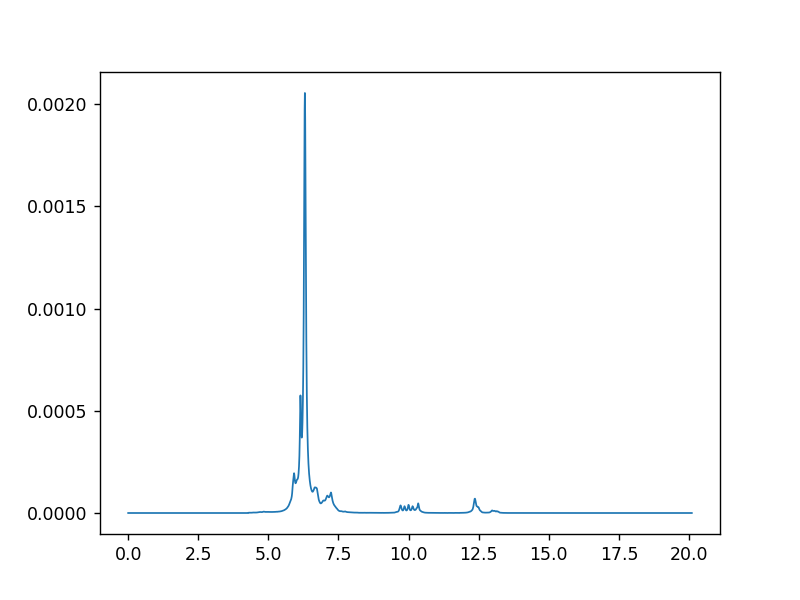

In [55]:
mix.plot(profile=True)
# comp0.plot(profile=True)
# comp1.plot(profile=True) 
# comp2.plot(profile=True)
# comp3.plot(profile=True) 
# comp4.plot(profile=True)
# comp5.plot(profile=True) 
# comp6.plot(profile=True)
# comp7.plot(profile=True) 
# comp8.plot(profile=True) 

### Cutting useless data points

In [56]:
for i, ints in enumerate(components_ints):
    components_ints[i] = components_ints[i][np.logical_and(components_ppm[i]>5, components_ppm[i]<16)]
    components_ppm[i] = components_ppm[i][np.logical_and(components_ppm[i]>5, components_ppm[i]<16)]

In [57]:
mix_ints = mix_ints[np.logical_and(ppm>5, ppm<16)]
ppm = ppm[np.logical_and(ppm>5, ppm<16)]

In [58]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(Spectrum(confs=list(zip(components_ppm[i], comp_ints))))

In [59]:
mix = Spectrum(confs=list(zip(ppm, mix_ints)))

In [60]:
spectra_and_mixture = spectra + [mix]

In [61]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [62]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [63]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [64]:
cma = common_mass_axis(spectra_and_mixture)

In [65]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [66]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [67]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [68]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [69]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


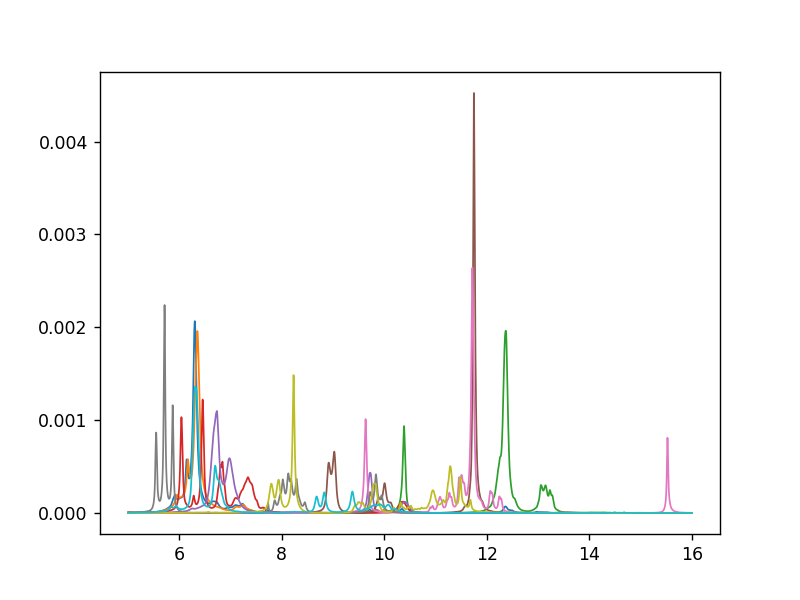

In [70]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True) 
comp4.plot(profile=True)
comp5.plot(profile=True) 
comp6.plot(profile=True)
comp7.plot(profile=True) 
comp8.plot(profile=True) 

### Heatmaps 21.11.2022. - shift in ppm for limonene, etanol included, solver GUROBI

In [71]:
import time
import pandas as pd
import pulp

In [72]:
lower_limit = 0.1
upper_limit = 1.1
step = 0.1

In [73]:
list_of_estimation_results = []
for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
    fixed_kappa = []
    for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
        start = time.time()
        estimation = estimate_proportions(mix, [comp0,comp1,comp2,comp3, comp4, comp5, comp6, comp7, comp8], 
                                   MTD=kappa, MTD_th=kappa_prime, verbose=True, solver=pulp.GUROBI())
        end = time.time()
        fixed_kappa.append((estimation['proportions'], 
                                           estimation['proportion_of_noise_in_theoretical']))
        print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
        print('It took: '+str(end-start)+' seconds.')
        print(estimation['proportions'])
    list_of_estimation_results.append(fixed_kappa)

Initial filtering of formulas: 100%|█████████████| 9/9 [00:00<00:00, 391.82it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(5.001421420000001, 15.998610000000001, 0), (5.001421420000001, 15.998610000000001, 1), (5.001421420000001, 15.998610000000001, 2), (5.001421420000001, 15.998610000000001, 3), (5.001421420000001, 15.998610000000001, 4), (5.001421420000001, 15.998610000000001, 5), (5.001421420000001, 15.998610000000001, 6), (5.001421420000001, 15.998610000000001, 7), (5.001421420000001, 15.998610000000001, 8)]


Computing chunks: 100%|███████████████████████| 9/9 [00:00<00:00, 397355.12it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Chunk bounds: [(4.901421420000001, 16.09861)]


Splitting the experimental spectrum into chunks: 21684it [00:00, 3696524.46it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Deconvolving chunk 0
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86742 rows, 21687 columns and 369299 nonzeros
Model fingerprint: 0x277805ad
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 1e-01]
Presolve removed 23688 rows and 526 columns
Presolve time: 10.82s
Presolved: 21686 rows, 86213 columns, 368235 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 525
 AA' NZ     : 2.609e+

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.06s/it]


Gurobi status= 2
Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.967933063698
Noise proportion in experimental spectrum: 0.032066936287999954
Total explanation: 0.999999999986
Noise proportion in combination of theoretical spectra: 0.081474940805
Estimation for 0.1 and 0.1 done
It took: 20.121187686920166 seconds.
[0.8865711618229978, 0.032919602674999916, 0.0, 0.041818022354999894, 0.0, 0.0, 0.006505880729999984, 0.0, 0.00011839611499999971]


Initial filtering of formulas: 100%|█████████████| 9/9 [00:00<00:00, 381.09it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(5.001421420000001, 15.998610000000001, 0), (5.001421420000001, 15.998610000000001, 1), (5.001421420000001, 15.998610000000001, 2), (5.001421420000001, 15.998610000000001, 3), (5.001421420000001, 15.998610000000001, 4), (5.001421420000001, 15.998610000000001, 5), (5.001421420000001, 15.998610000000001, 6), (5.001421420000001, 15.998610000000001, 7), (5.001421420000001, 15.998610000000001, 8)]


Computing chunks: 100%|███████████████████████| 9/9 [00:00<00:00, 352791.93it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Chunk bounds: [(4.8014214200000005, 16.198610000000002)]


Splitting the experimental spectrum into chunks: 21684it [00:00, 3276389.20it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86742 rows, 21687 columns and 369299 nonzeros
Model fingerprint: 0xcbc685ab
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 2e-01]
Presolve removed 23688 rows and 526 columns
Presolve time: 11.23s

Stopped in 0 iterations and 11.24 seconds (77.52 work units)
Solve interrupted


Deconvolving chunks:   0%|                                | 0/1 [00:15<?, ?it/s]

Gurobi status= 11


TypeError: type NoneType doesn't define __round__ method

In [ ]:
# pd.DataFrame(list_of_estimation_results, 
#              columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#             index=np.arange(start=lower_limit, stop=upper_limit, step=step)).to_excel('results_for_heatmap_15_10.xlsx')

In [ ]:
pd.DataFrame(list_of_estimation_results, 
             columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
            index=np.arange(start=lower_limit, stop=upper_limit, 
                            #step=step)).to_pickle('results_for_heatmap_17_11_no_comp6.pkl')
pd.DataFrame(list_of_estimation_results, 
             columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
            index=np.arange(start=lower_limit, stop=upper_limit, 
                            #step=step)).to_pickle('results_for_heatmap_17_11_with_comp6.pkl')

In [76]:
# list_of_estimation_results = pd.read_pickle('results_for_heatmap_17_11_no_comp6.pkl')
list_of_estimation_results = pd.read_pickle('results_for_heatmap_17_11_with_comp6.pkl')

In [77]:
list_of_estimation_results = list_of_estimation_results.values.tolist()

In [78]:
dataframes_with_results_for_heatmap = []
for component_number in range(len([comp0,comp1,comp2,comp3, comp4, comp5, comp6, comp7, comp8])):
    new_dataframe = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
                                   index=np.arange(start=lower_limit, stop=upper_limit, step=step))

In [79]:
list_of_dataframes_with_results = []
for component_number in range(len([comp0,comp1,comp2,comp3, comp4, comp5, comp6, comp7, comp8])):
    results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
                                   index=np.arange(start=lower_limit, stop=upper_limit, step=step))
    for i in range(results_for_component.shape[0]):
        for j in range(results_for_component.shape[1]):
            results_for_component.iloc[i,j] = list_of_estimation_results[i][j][0][component_number]
    
    list_of_dataframes_with_results.append(results_for_component)

In [81]:
dataframes_ready_for_heatmap = []
all_proportions = vis_prop + [0, 0, 0, 0, 0]
for i, df in enumerate(list_of_dataframes_with_results):
    if all_proportions[i] != 0:
        preprocessed_df = (abs(df - all_proportions[i]))/all_proportions[i]
    else:
        preprocessed_df = abs(df - all_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [82]:
dataframes_ready_for_heatmap[0]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.1,0.02848,0.021917,0.025146,0.024621,0.024458,0.025169,0.024832,0.024727,0.024701,0.024684
0.2,0.056381,0.008693,0.002247,0.005328,0.007449,0.008018,0.008408,0.008446,0.008526,0.008563
0.3,0.054735,0.004659,0.001849,0.003678,0.004926,0.007073,0.008585,0.0091,0.009214,0.009254
0.4,0.05443,0.000632,0.001885,0.009397,0.012508,0.015182,0.017503,0.020015,0.022031,0.022665
0.5,0.054429,0.00064,0.001836,0.01314,0.018707,0.023008,0.026075,0.029362,0.031861,0.033529
0.6,0.054429,0.00064,0.001836,0.01314,0.018692,0.022931,0.025793,0.029149,0.032118,0.034198
0.7,0.054429,0.00064,0.001836,0.01314,0.018692,0.022927,0.025627,0.029027,0.03197,0.034112
0.8,0.054429,0.00064,0.001836,0.01314,0.018692,0.022927,0.025614,0.028881,0.031815,0.034061
0.9,0.054429,0.00064,0.001836,0.01314,0.018692,0.022927,0.025614,0.028815,0.031746,0.033987
1.0,0.054429,0.00064,0.001836,0.01314,0.018692,0.022927,0.025614,0.028813,0.031704,0.033934


In [83]:
import seaborn as sns

<IPython.core.display.Javascript object>


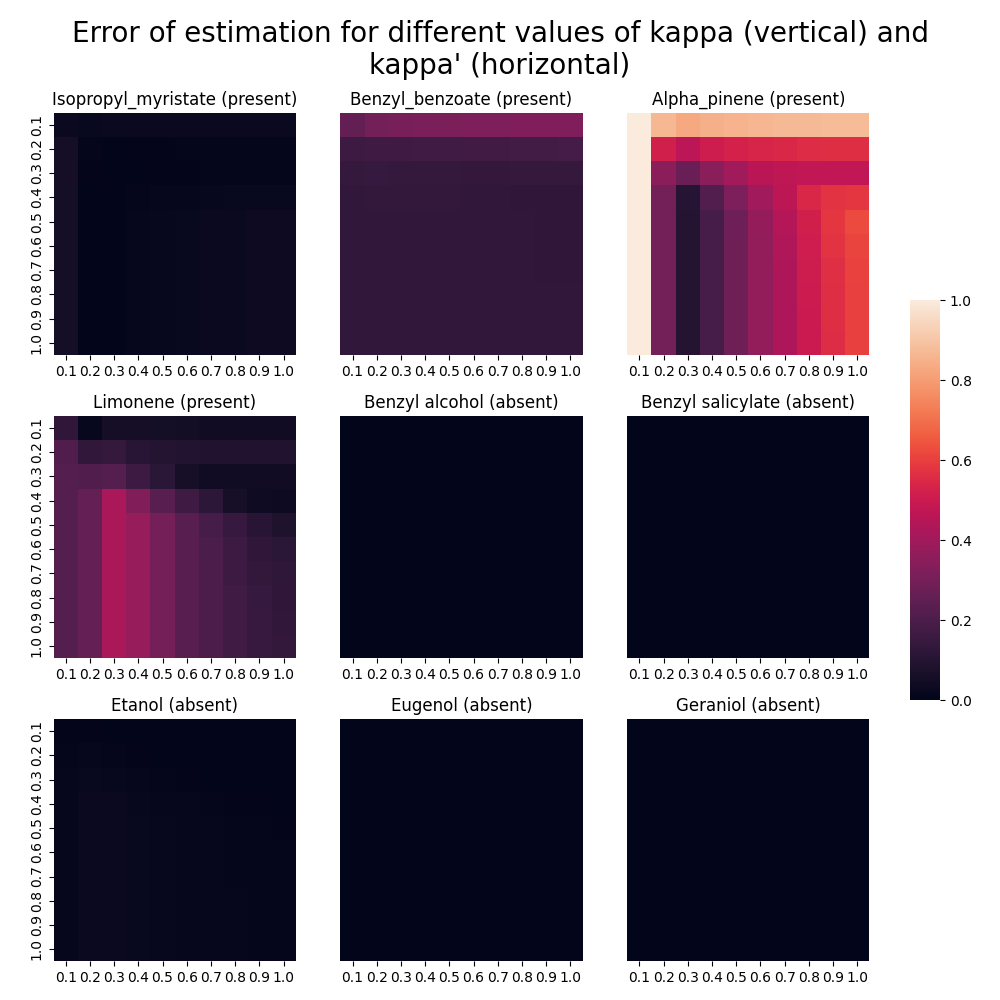

/tmp/ipykernel_33659/1376672719.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [86]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,1) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = ['Isopropyl_myristate (present)', 'Benzyl_benzoate (present)', 'Alpha_pinene (present)',
                    'Limonene (present)', 'Benzyl alcohol (absent)', 'Benzyl salicylate (absent)', 
                    'Etanol (absent)', 'Eugenol (absent)', 'Geraniol (absent)']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10), gridspec_kw=dict(width_ratios=3*[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')


for i, ax in enumerate(axs.ravel()):
    ax.set_title(names_for_plot[i])
    if i%3==0:
        ax.set_ylabel('kappa')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    if i%3==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True),
                )

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =20)


plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [85]:
from textwrap import wrap

### Which values are the best?

In [91]:
sum(dataframes_ready_for_heatmap).astype(float)

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.1,1.419102,1.204413,1.221925,1.238142,1.247439,1.252240,1.259584,1.261727,1.263200,1.264535
0.2,1.437810,0.836462,0.780431,0.791426,0.800737,0.811944,0.818409,0.829813,0.832793,0.833887
0.3,1.428515,0.728107,0.648882,0.659545,0.663785,0.668057,0.659358,0.664359,0.666649,0.667305
0.4,1.420210,0.719800,0.682445,0.702889,0.708001,0.726433,0.744165,0.760427,0.763833,0.766050
0.5,1.419622,0.717820,0.677103,0.724108,0.744254,0.770427,0.796045,0.832784,0.858455,0.871091
0.6,1.419622,0.717820,0.677103,0.724108,0.744366,0.770553,0.796953,0.835167,0.868579,0.894915
0.7,1.419622,0.717820,0.677103,0.724108,0.744366,0.770567,0.797904,0.837219,0.872170,0.900167
0.8,1.419622,0.717820,0.677103,0.724108,0.744366,0.770567,0.798162,0.838815,0.875241,0.904552
0.9,1.419622,0.717820,0.677103,0.724108,0.744366,0.770567,0.798162,0.838692,0.876595,0.907567
1.0,1.419622,0.717820,0.677103,0.724108,0.744366,0.770567,0.798162,0.838728,0.877101,0.909790


<IPython.core.display.Javascript object>


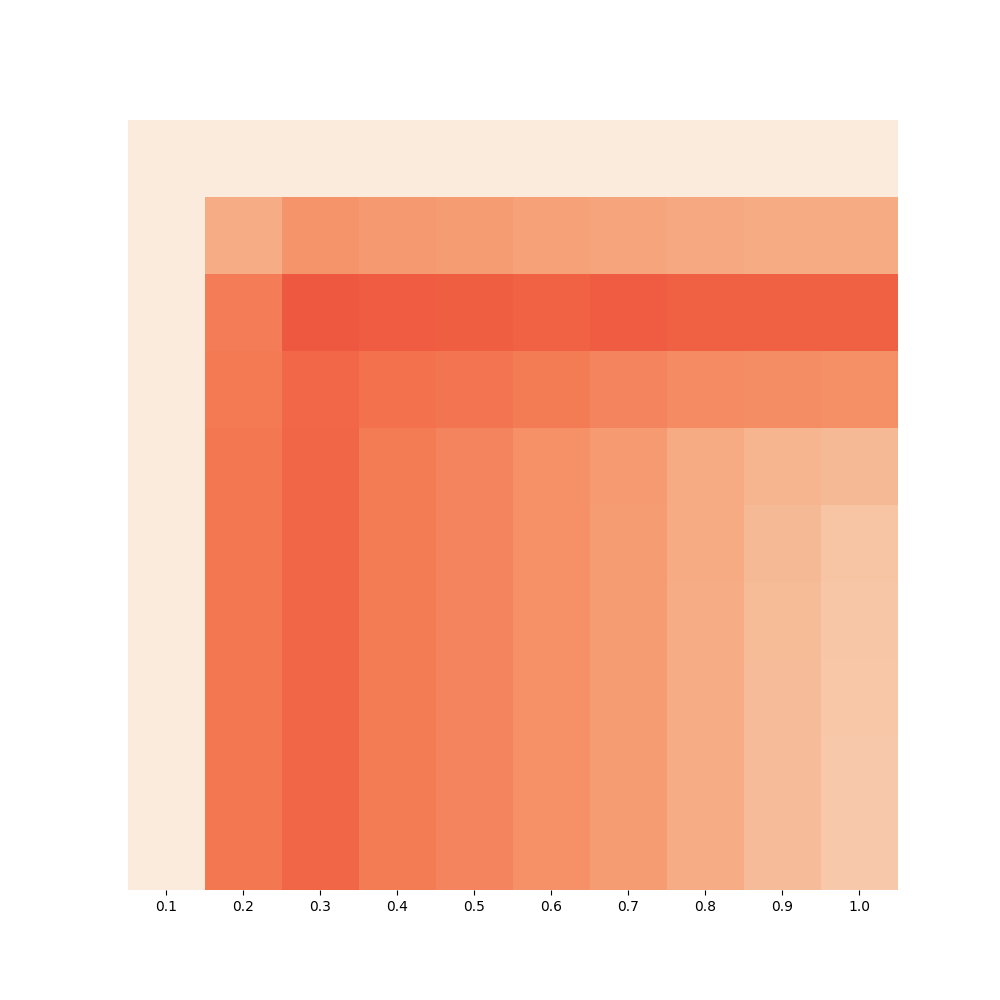

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), gridspec_kw=dict(width_ratios=[1]))

sns.heatmap(sum(dataframes_ready_for_heatmap).astype(float), yticklabels=False, cbar=False,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True))

plt.show()

To check:

- In an old version of this notebook (without absent components) are there any problems with spectra? Does shift work as expected



### Estimation in Batman

In [60]:
# #From email: 2.2449, 0.3269, 0.2533, 0.2651
# r_sum = 2.2449 + 0.3269 + 0.2533 + 0.2651
# real_proportions = [2.2449/r_sum, 0.3269/r_sum, 0.2533/r_sum, 0.2651/r_sum]
# print('Real proportions:')
# real_proportions

Real proportions:


[0.7264578344443725,
 0.10578603326645526,
 0.081968804608116,
 0.08578732768105625]

In [61]:
#BATMAN:
#0.44247709 0.08768463 0.03415340 0.09843556 0.27391114 0.06333818

In [62]:
# print('Batman estimation:')
# real_visible_proportions/sum(real_visible_proportions)

Batman estimation:


array([0.86202083, 0.0443035 , 0.0457717 , 0.04790398])

In [89]:
### Co tu się wydarzyło poniżej xd? Usunięcie komentarza sprawia, że znika pasek z kolorami? 

<IPython.core.display.Javascript object>


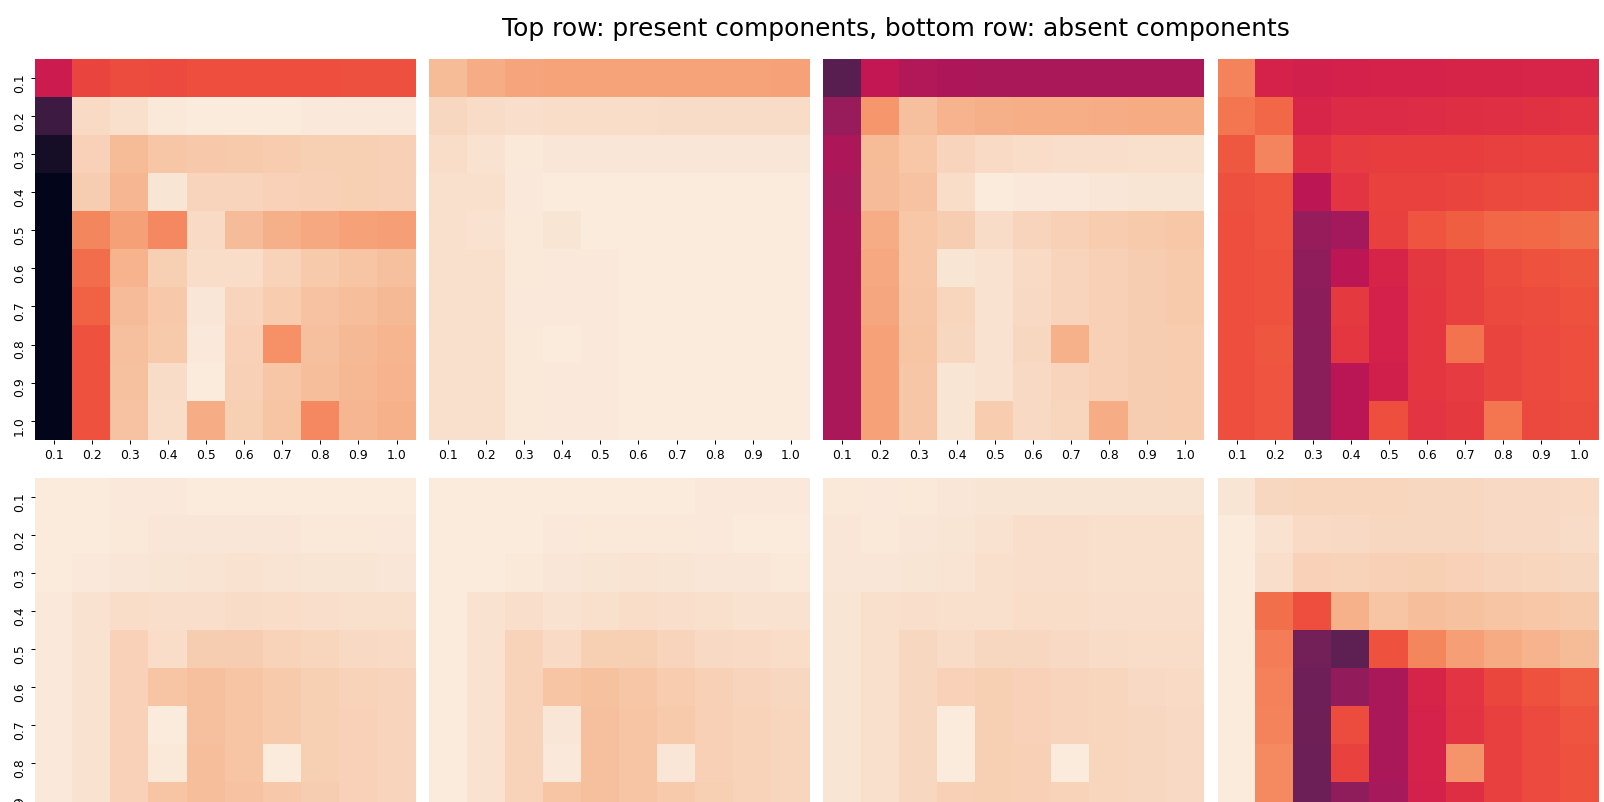

/home/basia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [88]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,1) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = ['Isopropyl_myristate (present)', 'Benzyl_benzoate (present)', 'Alpha_pinene (present)',
                    'Limonene (present)', 'Benzyl alcohol (absent)', 'Benzyl salicylate (absent)', 
                    'Eugenol (absent)', 'Geraniol (absent)']

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,10), gridspec_kw=dict(width_ratios=4*[1]))

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    
    if i%4==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax, 
                cmap=sns.color_palette("rocket_r", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket_r", as_cmap=True),
                )
        


plt.suptitle('Top row: present components, bottom row: absent components', fontsize =20)


#plt.show()
fig.tight_layout(rect=[0, 0, .9, 1])

Note: horizontal axis -> kappa', vertical axis -> kappa.

### Wizualizacja najlepszej estymacji

In [74]:
estimation = estimate_proportions(mix, [comp0, comp1,comp3, comp4, comp5, comp6, comp7, comp8], 
                                   MTD=0.3, MTD_th=0.3, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|█████████████| 8/8 [00:00<00:00, 378.91it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(5.001421420000001, 15.998610000000001, 0), (5.001421420000001, 15.998610000000001, 1), (5.001421420000001, 15.998610000000001, 2), (5.001421420000001, 15.998610000000001, 3), (5.001421420000001, 15.998610000000001, 4), (5.001421420000001, 15.998610000000001, 5), (5.001421420000001, 15.998610000000001, 6), (5.001421420000001, 15.998610000000001, 7)]


Computing chunks: 100%|███████████████████████| 8/8 [00:00<00:00, 310689.19it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0, 0, 0, 0]
Chunk bounds: [(4.701421420000001, 16.29861)]


Splitting the experimental spectrum into chunks: 21684it [00:00, 2591443.13it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86741 rows, 21687 columns and 350000 nonzeros
Model fingerprint: 0xb5bff52f
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23962 rows and 526 columns
Presolve time: 10.17s
Presolved: 21686 rows, 86212 columns, 348937 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Interrupt request received
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 9
 Free vars  : 525
 AA' NZ     : 2.416e+05
 Factor NZ  : 5.715e+05 (roughly 50 MB of memory)
 Factor Ops

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.51s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.9804273785259999
Noise proportion in experimental spectrum: 0.019572621468999966
Total explanation: 0.9999999999949999
Noise proportion in combination of theoretical spectra: 0.005287322622


In [104]:
estimation['proportions']

[0.8799122853309979,
 0.0386577980869999,
 0.04825912902699988,
 0.0,
 0.0,
 0.013598166080999967,
 0.0,
 0.0]

In [76]:
vis_prop

[0.8620208303686988,
 0.04430349725220739,
 0.04577169717134345,
 0.04790397520775029]

In [79]:
estimation = estimate_proportions(mix, [comp0, comp1,comp2,comp3, comp4, comp5, comp6, comp7, comp8], 
                                   MTD=0.3, MTD_th=0.3, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|█████████████| 9/9 [00:00<00:00, 396.92it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(5.001421420000001, 15.998610000000001, 0), (5.001421420000001, 15.998610000000001, 1), (5.001421420000001, 15.998610000000001, 2), (5.001421420000001, 15.998610000000001, 3), (5.001421420000001, 15.998610000000001, 4), (5.001421420000001, 15.998610000000001, 5), (5.001421420000001, 15.998610000000001, 6), (5.001421420000001, 15.998610000000001, 7), (5.001421420000001, 15.998610000000001, 8)]


Computing chunks: 100%|███████████████████████| 9/9 [00:00<00:00, 166293.99it/s]


Number of chunks: 1
ChunkIDs: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Chunk bounds: [(4.701421420000001, 16.29861)]


Splitting the experimental spectrum into chunks: 21684it [00:00, 2512966.62it/s]


Ion currents in chunks: [0.9999999999999976]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 86742 rows, 21687 columns and 369299 nonzeros
Model fingerprint: 0xce8595d7
Coefficient statistics:
  Matrix range     [1e-11, 1e+00]
  Objective range  [2e-09, 1e+00]
  Bounds range     [2e-15, 2e-15]
  RHS range        [9e-16, 3e-01]
Presolve removed 23688 rows and 526 columns
Presolve time: 11.14s
Presolved: 21686 rows, 86213 columns, 368235 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 10
 Free vars  : 525
 AA' NZ     : 2.609e+05
 Factor NZ  : 5.941e+05 (roughly 50 MB of memory)
 Factor Ops : 1.769e+07 (less than 1 s

Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.37s/it]


In [80]:
estimation['proportions']

[0.8636149797079979,
 0.03810142039599991,
 0.033383095182999915,
 0.03735284088199991,
 0.0,
 0.0,
 0.01612519385599996,
 0.0,
 0.0]

In [81]:
[abs(estimation['proportions'][i]-vis_prop[i])/vis_prop[i] for i, _ in enumerate(estimation['proportions'][:4])]

[0.0018493164934509677,
 0.13999068337428974,
 0.27066075225411873,
 0.22025592406459274]

# Real proportions:
# 0.8620, 0.0443, 0.0458, 0.0479, 0, 0, 0, 0

# Estimated proportions
# 0.8694, 0.0383, 0.0243, 0.0457, 0, 0, 0, 0, 0.0002

### Visualisation of our estimation

In [174]:
p = estimation['proportions'][:4]

In [175]:
p = np.array(p).reshape(len(p),1)

In [176]:
p = p[[0, 3, 1, 2],:]

In [178]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(4)]

In [179]:
components_ints = []
for spectrum in [comp0, comp3, comp1,comp2]:
    components_ints.append(np.array(spectrum.confs)[:,1].reshape(-1,1))
    components_ppm.append(np.array(spectrum.confs)[:,0])

In [180]:
X = np.concatenate(components_ints[:4], axis=1)

In [181]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

In [183]:
names_switched = [official_names[0], official_names[3], official_names[1], official_names[2]] + official_names[4:]

In [184]:
names_switched

['Isopropyl_myristate',
 'Limonene',
 'Benzyl_benzoate',
 'Alpha_pinene',
 'Benzyl alcohol',
 'Benzyl salicylate',
 'Etanol',
 'Eugenol',
 'Geraniol',
 'Menthone']

<IPython.core.display.Javascript object>


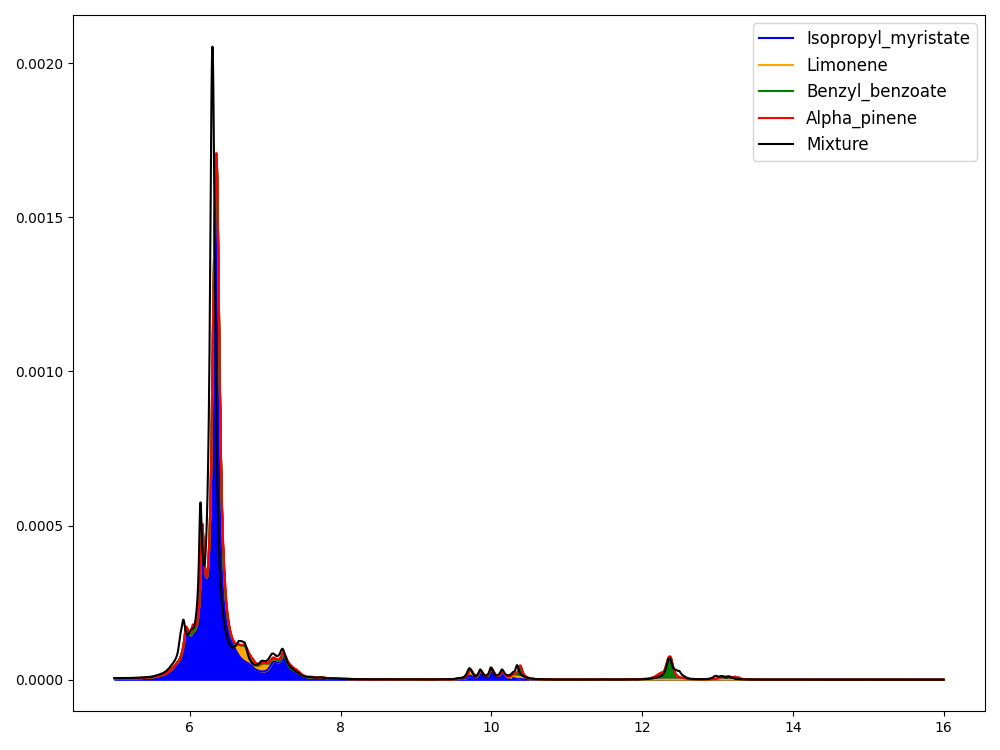

In [199]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(10, 7.5, forward=True)
# ax.set_xlim(5,8)
# ax.set_xlim(9.35,10.7)
# ax.set_ylim(-0.00001,0.0001)
# ax.set_xlim(11.9, 13.5)
# ax.set_ylim(-0.00001,0.0001)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=names_switched[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture')
ax.legend(prop={'size': 12})
plt.tight_layout()

### Visualisation of spectrum in real proportions

In [119]:
real_p = np.array(vis_prop).reshape(len(vis_prop),1)

In [122]:
real_p.shape

(4, 1)

In [123]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(4)]

In [124]:
X = np.concatenate(components_ints[:4], axis=1)

In [125]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],real_p[:(i+1),:])[:,0]

In [126]:
names_matmul

['sum_up_to_1', 'sum_up_to_2', 'sum_up_to_3', 'sum_up_to_4']

<IPython.core.display.Javascript object>


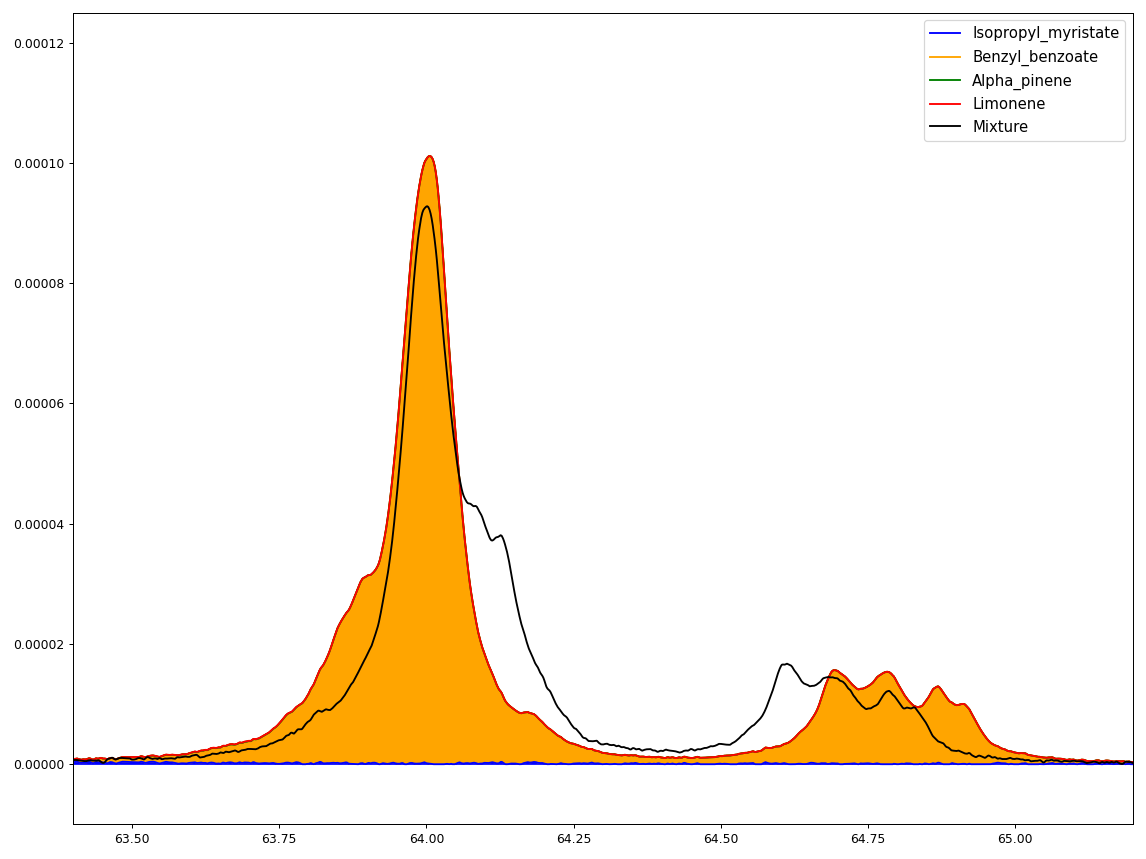

In [150]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(12.8, 9.6, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.003)
# ax.set_xlim(61,62.4)
# ax.set_ylim(-0.00001,0.00008)
# ax.set_xlim(63.4,65.2)
# ax.set_ylim(-0.00001,0.000125)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor], globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture')
ax.legend(prop={'size': 12})
plt.tight_layout()